<a href="https://colab.research.google.com/github/yashlal/Deepfake-Microbiomes/blob/main/NetGPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Streaming output truncated to the last 5000 lines.
File 3: Epoch 0: 0.29106530143154696
File 3: Epoch 1: 0.29046307021113527
File 3: Epoch 2: 0.291153983694151
File 3: Epoch 3: 0.29148384165759794
File 3: Epoch 4: 0.292280252799808
File 3: Epoch 5: 0.2915965816330471
File 3: Epoch 6: 0.2920047540416476
File 3: Epoch 7: 0.29088260503563834
File 3: Epoch 8: 0.29140920714240687
File 3: Epoch 9: 0.2908751129310825
File 3: Epoch 10: 0.2915643472807199
File 3: Epoch 11: 0.29192309375433595
File 3: Epoch 12: 0.2912488297410301
File 3: Epoch 13: 0.29136530458102994
File 3: Epoch 14: 0.29264010751973724
File 3: Epoch 15: 0.29136483151216835
File 3: Epoch 16: 0.2907370956161575
File 3: Epoch 17: 0.2916589576973988
File 3: Epoch 18: 0.29106173054087814
File 3: Epoch 19: 0.29126489447708814
File 3: Epoch 20: 0.2910549342085679
File 3: Epoch 21: 0.29072458960441605
File 3: Epoch 22: 0.2917278202978106
File 3: Epoch 23: 0.29110208289545586
File 3: Epoch 24: 0.29152886365318026
File 3: Epoch 25: 0.29

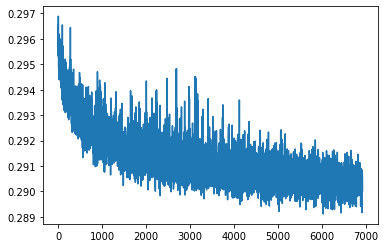

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pickle
import numpy as np
import torch.optim as optim
import time
from math import sqrt
import matplotlib.pyplot as plt

f_min = 8
f_max = 18

# select CUDA if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if str(device) == 'cuda:0':
	print('CUDA device selected!')
elif str(device) == 'cpu':
	print('CUDA device not available. CPU selected')

class MyNet(nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()
        self.fc1 = nn.Linear(462, 462*5)
        self.fc2 = nn.Linear(462*5, 462*5)
        self.fc3 = nn.Linear(462*5, 462*10)
        self.fc4 = nn.Linear(462*10, 231*461)
        self.dropout = nn.Dropout(0.1)
    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
       	x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.fc4(x)
        return x

net = MyNet().to(device)
net.load_state_dict(torch.load('model.pth'))
net.eval()
criterion = nn.MSELoss(reduction='mean')
optimizer = optim.Adam(net.parameters(), lr=1e-4)

loss_v = []

for n in range(f_min,f_max+1):
    d_PATH = f'drive/MyDrive/YashData/{n}'
    f = open(d_PATH, 'rb')
    data = pickle.load(f)

    for i in range(1000):
        optimizer.zero_grad()

        input = torch.from_numpy(data[i][1]).float().to(device)
        true_y = torch.FloatTensor(data[i][0]).to(device)

        output = net(input).to(device)

        loss = criterion(output, true_y).to(device)
        loss_v.append(sqrt(loss.item()))
        loss.backward()

        optimizer.step()

        print(f'File {n}: Epoch {i}: {sqrt(loss.item())}')

PATH = 'model.pth'
torch.save(net.state_dict(), PATH)

plt.plot(loss_v)
img_path = f'Loss{f_min}to{f_max}'
plt.savefig('Loss.png')
plt.show()
